Tutorial on Computing HFOs (Part 3)
==========================

In this tutorial, we will walk through how to compare detectors. As in part 2, we will demonstrate this on a sample dataset that is defined in [1]. 

We will demonstrate compar of the following detectors:

- Line Length detector
- RMS detector
- Morphology detector (used in the paper)

Dataset Preprocessing
---------------------
Note that the data has been converted to BIDS to facilitate easy loading using ``mne-bids`` package. Another thing to note is that the authors in this dataset 
reported HFOs detected using bipolar montage. In addition, they only analyzed HFOs for a subset of the recording channels.

In order to compare results to a monopolar reference, we define an HFO to be "found" if there was an HFO in either of the corresponding bipolar contacts.

References
----------
[1] Fedele T, Burnos S, Boran E, Krayenbühl N, Hilfiker P, Grunwald T, Sarnthein J. Resection of high frequency oscillations predicts seizure outcome in the individual patient.
Scientific Reports. 2017;7(1):13836.
https://www.nature.com/articles/s41598-017-13064-1
doi:10.1038/s41598-017-13064-1

In [1]:
# first let's load in all our packages
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import re
import pandas as pd


from mne_bids import (read_raw_bids, BIDSPath, 
                      get_entity_vals, get_datatypes, 
                      make_report)
from mne_bids.stats import count_events

import mne
from mne import make_ad_hoc_cov

basepath = os.path.join(os.getcwd(), "../..")
sys.path.append(basepath)
from mne_hfo import LineLengthDetector, RMSDetector
from mne_hfo.compare import compare

# 1 Working with Real Data
We are now going to work with the dataset from Fedele et al. linked above

## 1.1 Load in Real Data
We are going to skip intermediate/display steps since you did this in part 2

In [2]:
%%capture
# this may change depending on where you store the data
root = "C:/Users/patri/Dropbox/fedele_hfo_data"
subjects = get_entity_vals(root, 'subject')
sessions = get_entity_vals(root, 'session')
subjectID = subjects[0]
sessionID = sessions[0]
bids_path = BIDSPath(subject=subjectID, session=sessionID,
                     datatype='ieeg', 
                     suffix='ieeg',
                     extension='.vhdr', root=root)

# get first matching dataset
fpath = bids_path.match()[0]
# load dataset into mne Raw object
extra_params = dict(preload=True)
raw = read_raw_bids(fpath, extra_params)

## 1.2 Perform pre-processing steps

In [3]:
def convert_to_bipolar(raw, drop_originals=True):
    original_ch_names = raw.ch_names
    ch_names_sorted = sorted(original_ch_names)
    ch_pairs = [] 
    for first, second in zip(ch_names_sorted, ch_names_sorted[1:]):
        firstName = re.sub(r'[0-9]+', '', first)
        secondName = re.sub(r'[0-9]+', '', second)
        if firstName == secondName:
            ch_pairs.append((first,second))
    for ch_pair in ch_pairs:
        raw = mne.set_bipolar_reference(raw, ch_pair[0], ch_pair[1], drop_refs=False)
    if drop_originals:
        raw = raw.drop_channels(original_ch_names)
    return raw

In [4]:
%%capture
raw = convert_to_bipolar(raw)

## 1.3 Perform Detection with Both Detectors

In [5]:
# Set Key Word Arguments for the Line Length Detector and generate the class object
kwargs = {
    'filter_band': (80, 250), # (l_freq, h_freq)
    'threshold': 3, # Number of st. deviations
    'win_size': 100, # Sliding window size in samples
    'overlap': 0.25, # Fraction of window overlap [0, 1]
    'hfo_name': "ripple"
}
ll_detector = LineLengthDetector(**kwargs)

# We use the same arguments for the RMS Detecor
rms_detector = RMSDetector(**kwargs)

In [6]:
%%capture
# perform the fits
ll_detector = ll_detector.fit(raw)
rms_detector = rms_detector.fit(raw)

# 2 Compare detections

## 2.1 Perform the comparisons
We will calculate both the mutual information and cohen kappa scores to find agreement between detectors

In [7]:
mutual_info = compare(ll_detector, rms_detector, method="mutual-info")
kappa = compare(ll_detector, rms_detector, method="cohen-kappa")

## 2.2 Visualize the comparisons

First let's observe what the compare function returns

In [8]:
mutual_info

{'AHR1-AHR2': 0.006367438905637873,
 'AHR2-AHR3': 0.009303055655412978,
 'AHR3-AHR4': 0.008639619380071323,
 'AHR4-AHR5': 0.040792175680735315,
 'AHR5-AHR6': 0.016727304440477292,
 'AHR6-AHR7': 0.008881367396859075,
 'AHR7-AHR8': 0.006652660795102627,
 'AL1-AL2': 0.12086053091711568,
 'AL2-AL3': 0.30498226655255134,
 'AL3-AL4': 0.3423289003563088,
 'AL4-AL5': 0.35410834336008845,
 'AL5-AL6': 0.2539488808327681,
 'AL6-AL7': 0.27710634259216566,
 'AL7-AL8': 0.20070048550752645,
 'AR1-AR2': 0.009177030068343972,
 'AR2-AR3': 0.02042497757073164,
 'AR3-AR4': 0.1327554225272446,
 'AR4-AR5': 0.16384897368786566,
 'AR5-AR6': 0.21741452983633036,
 'AR6-AR7': 0.14966156088411725,
 'AR7-AR8': 0.029084598353392555,
 'HL1-HL2': 0.02621331380334116,
 'HL2-HL3': 0.0818495271081513,
 'HL3-HL4': 0.08274279480227631,
 'HL4-HL5': 0.03552038185412143,
 'HL5-HL6': 0.36575250233949996,
 'HL6-HL7': 0.26926841245696487,
 'HL7-HL8': 0.2612247225578799,
 'IAR1-IAR2': 0.2116504273602524,
 'IAR2-IAR3': 0.09870475

As you can see, the compare function gives a dictionary where the keys are the channels and the values are the metric value, in this case the mutual information. We can use these values to plot a heatmap that easily shows us where the detectors are similar and where they are not. Since we do not care about similar detections in different channels, this is equivalent to the diagonal for a traditional mutual info map.

### 2.1.1 Extract the right values

In [9]:
ch_names = list(mutual_info.keys())
mutual_info_vals = list(mutual_info.values())
mutual_info_vals = np.reshape(mutual_info_vals, (1, len(mutual_info_vals)))
kappa_vals = list(kappa.values())
kappa_vals = np.reshape(kappa_vals, (1, len(kappa_vals)))

### 2.1.2 Visualize the mutual info

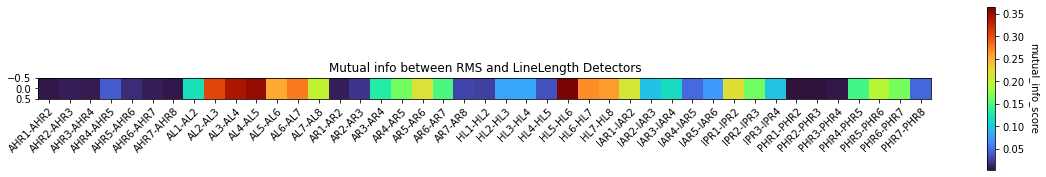

In [10]:
fig, ax = plt.subplots(figsize=(20, 3))
im = ax.imshow(mutual_info_vals, cmap='turbo')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("mutual_info_score", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(ch_names)))
ax.set_xticklabels(ch_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_title("Mutual info between RMS and LineLength Detectors")
#fig.tight_layout()
plt.show()

### 2.1.3 Visualize the Kappa score

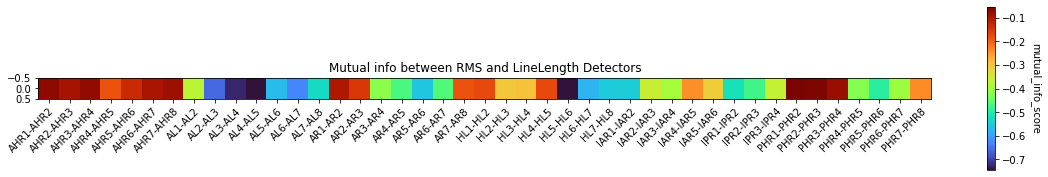

In [11]:
fig, ax = plt.subplots(figsize=(20, 3))
im = ax.imshow(kappa_vals, cmap='turbo')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("mutual_info_score", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(ch_names)))
ax.set_xticklabels(ch_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax.set_title("Mutual info between RMS and LineLength Detectors")
#fig.tight_layout()
plt.show()